### Libs

In [517]:
import requests
import json
import numpy as np
import pandas as pd
from IPython.display import clear_output

### Data

In [518]:
with open('dataset\cvrp_castanhal_completo.json') as json_file:
    raw_data = json.load(json_file)

In [519]:
raw_data.keys()

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])

In [520]:
raw_data["origin"]

{'lng': -47.93317089927402, 'lat': -1.2923387357484621}

In [521]:
raw_data["vehicle_capacity"]

180

In [522]:
raw_data["deliveries"][0]

{'id': '245aed8b07925496f14cc83f85a95318',
 'point': {'lng': -48.083796008609376, 'lat': -1.3859328704379723},
 'size': 8}

### General Class

In [523]:
class Coordinate:
    def __init__(self, lat, lng):
        self.lat = lat
        self.lng = lng

In [524]:
class Delivery:
    def __init__(self, raw_delivery, index):
        self.id = index+1
        self.point = Coordinate(str(raw_delivery["point"]["lat"]), str(raw_delivery["point"]["lng"]))
        self.size = raw_delivery["size"]

In [525]:
class DepotNet:
    def __init__(self, raw_data):
        self.name = raw_data["name"]
        self.region = raw_data["region"]
        self.origin = Coordinate(str(raw_data["origin"]["lat"]), str(raw_data["origin"]["lng"]))
        self.vehicle_capacity = raw_data["vehicle_capacity"]
        self.deliveries = [Delivery(raw_data["deliveries"][i], i) for i in range(len(raw_data["deliveries"]))]

### Tabu Search

In [526]:
#Class Tabu Search for the problem of the CVRP
class TabuSearch:
    def __init__(self, depot_net, max_iterations, n_neighbors, tabu_list_size):
        self.depot_net = depot_net
        self.max_iterations = max_iterations
        self.n_neighbors = n_neighbors
        self.tabu_list_size = tabu_list_size
        self.solution = []
        self.best_solution = []
        self.best_solutions = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.best_neighborhood = pd.DataFrame(columns=[f"x_{i}" for i in range(len(self.depot_net.deliveries))]+["y"])
        self.tabu_list = []
        self.run()

    def generate_solution_initial(self):
        n = len(self.depot_net.deliveries)
        solution = np.random.choice([i for i in range(n)], n, replace=False)
        return [self.depot_net.deliveries[idx].id for idx in solution]
    
    def udpate_best_solutions(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_solutions = self.best_solutions.append(s, ignore_index=True)
        df = self.best_solutions.iloc[:, :-1].astype(int)
        df["y"] = self.best_solutions["y"]
        self.best_solutions = df

    def udpate_best_neighborhood(self, solution, solution_cost):
        s = pd.Series([self.depot_net.deliveries[idx-1].id for idx in solution]+[solution_cost],index=[f"x_{i}" for i in range(len(solution))]+["y"])
        self.best_neighborhood = self.best_neighborhood.append(s, ignore_index=True)
        df = self.best_neighborhood.iloc[:, :-1].astype(int)
        df["y"] = self.best_neighborhood["y"]
        self.best_neighborhood = df
    
    def solution_cost(self, solution, save=False):
        solution_cost = 0
        route_list = [f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}"]
        weight = 0
        for delivery in [self.depot_net.deliveries[idx-1] for idx in solution]:
            weight += delivery.size
            if weight <= self.depot_net.vehicle_capacity:
                route_list.append(f"{delivery.point.lng},{delivery.point.lat}")
            else:
                route_list.append(f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}")
                route_list.append(f"{delivery.point.lng},{delivery.point.lat}")
                weight = 0
        route_list.append(f"{self.depot_net.origin.lng},{self.depot_net.origin.lat}")
        route_str = ";".join(route_list)
        query = f"https://router.project-osrm.org/route/v1/driving/{route_str}?overview=false"
        #print(query)
        response = requests.get(query)
        data = response.json()
        #salvar resposta da requisição em arquivo no formato json
        if save:
            with open('best_routes_cvrp.json', 'w') as outfile:
                json.dump(data, outfile)
        solution_cost = data["routes"][0]["distance"]
        return solution_cost
    
    def swap(self, solution):
        i, j = np.random.choice(len(solution)-1, 2, replace=False)
        solution[i], solution[j] = solution[j], solution[i]
        return solution
    
    def diference_solutions(self, solution, best_neighbor):
        indexs = [i for i in range(len(solution)) if solution[i] != best_neighbor[i]]
        return indexs
    
    def generate_neighbors(self, iteration):
        neighbors = []
        neighbors_cost = []
        for _ in range(self.n_neighbors):
            neighbor = self.swap(self.solution.copy())
            while neighbor in neighbors:
                neighbor = self.swap(self.solution.copy())
            neighbor_cost = self.solution_cost(neighbor)
            if neighbors_cost == []:
                neighbors.append(neighbor)
                neighbors_cost.append(neighbor_cost)
            else:
                for k in range(len(neighbors_cost)):
                    if neighbor_cost < neighbors_cost[k]:
                        neighbors.insert(k, neighbor)
                        neighbors_cost.insert(k, neighbor_cost)
                        break
                    if k == len(neighbors_cost)-1:
                        neighbors.append(neighbor)
                        neighbors_cost.append(neighbor_cost)
        self.update_tabu_list(neighbors, neighbors_cost, iteration)
    
    def update_tabu_list(self, neighbors, neighbors_cost, iteration):
        if neighbors_cost[0] < self.solution_cost(self.best_solution):
            if len(self.tabu_list) == self.tabu_list_size:
                self.tabu_list.pop(0)
            self.tabu_list.append(self.diference_solutions(self.solution, neighbors[0]))
            self.solution = neighbors[0]
            #print(f'Mudou para melhor na iteração {iteration}')
            self.best_solution = neighbors[0]
            self.udpate_best_neighborhood(neighbors[0], neighbors_cost[0])
        else:
            for l in range(self.n_neighbors):
                indexs_swap = self.diference_solutions(self.solution, neighbors[l])
                if indexs_swap in self.tabu_list:
                    continue
                else:
                    if len(self.tabu_list) == self.tabu_list_size:
                        self.tabu_list.pop(0)
                    self.tabu_list.append(indexs_swap)
                    self.solution = neighbors[l]
                    #print(f'Mudou para pior na iteração {iteration}')
                    self.udpate_best_neighborhood(neighbors[l], neighbors_cost[l])
                    break
                
    def progress_bar(self, i):
        clear_output(wait=True)
        pc = int(i/self.max_iterations*100)
        logic_char = 0 if i == 1 else int(pc/2)
        print(f"Executando iteração {i}/{self.max_iterations}:|{'█' * logic_char + '.' * (50 - logic_char)}|{pc}%",
              end='\r', flush=True)

    def run(self):
        self.solution = self.generate_solution_initial()
        self.best_solution = self.solution
        initial = [self.solution, self.solution_cost(self.solution)]
        for i in range(self.max_iterations):
            self.progress_bar(i+1)
            self.generate_neighbors(i)
            self.udpate_best_solutions(self.best_solution, self.solution_cost(self.best_solution))
        #limpar a tela
        clear_output(wait=True)
        print(f'Solução inicial:\n{initial[0]}\nCusto: {initial[1]}')
        print(f'Após {i+1} iterações, temos:')
        print(f'Solução Final:\n{self.best_solution}\nCusto: {self.solution_cost(self.best_solution)}')

### Run

In [527]:
depot_net = DepotNet(raw_data)
max_iterations = 100
n_neighbors = 10
tabu_list_size = 5

#Criar instância do algoritmo (com execução automática)
tabu = TabuSearch(depot_net, max_iterations, n_neighbors, tabu_list_size)

Solução inicial:
[12, 11, 25, 5, 19, 13, 14, 28, 21, 26, 32, 34, 18, 3, 6, 33, 15, 4, 2, 7, 22, 10, 23, 8, 24, 17, 1, 9, 16, 30, 31, 35, 27, 29, 20]
Custo: 380354.7
Após 98 iterações, temos:
Solução Final:
[35, 7, 15, 8, 12, 26, 10, 21, 28, 11, 22, 9, 3, 1, 2, 6, 5, 4, 34, 31, 23, 27, 18, 33, 14, 13, 17, 24, 25, 19, 16, 30, 32, 29, 20]
Custo: 150396.8


### Analysis

##### Save response request OSRM

In [528]:
tabu.solution_cost(tabu.best_solution, save=True)

with open('best_routes_cvrp.json', 'r') as outfile:
    data = json.load(outfile)     

##### Best neighborhood

In [536]:
print(f'Melhores soluções das vizinhanças:')
display(tabu.best_neighborhood)
best_cost_neighborhood = tabu.best_neighborhood["y"].min()
index_best_neighborhood = tabu.best_neighborhood.loc[tabu.best_neighborhood["y"] == best_cost_neighborhood].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_neighborhood.astype(int).tolist()}')

Melhores soluções das vizinhanças:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,12,11,25,5,19,13,14,28,21,26,...,1,9,16,30,31,35,33,29,20,377016.7
1,12,11,25,5,19,13,14,28,21,26,...,1,2,16,30,31,35,33,29,20,369827.5
2,12,11,13,5,19,25,14,28,21,26,...,1,2,16,30,31,35,33,29,20,368573.8
3,12,23,13,5,19,25,14,28,21,26,...,1,2,16,30,31,35,33,29,20,366534.5
4,12,23,13,5,19,25,14,28,21,26,...,1,2,16,30,31,35,33,29,20,366534.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8,28,18,7,33,34,14,21,10,11,...,19,24,13,17,15,30,32,29,20,155137.2
96,8,28,18,7,33,34,14,10,21,11,...,19,24,13,17,15,30,32,29,20,155065.9
97,8,28,18,15,33,34,14,10,21,11,...,19,24,13,17,7,30,32,29,20,155252.1
98,8,28,18,15,33,34,14,10,21,11,...,25,24,13,17,7,30,32,29,20,154906.2


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[70]


##### Best solutions

In [530]:
print(f'Melhores soluções globais por iteração:')
display(tabu.best_solutions)
index_best_solutions = tabu.best_solutions.loc[tabu.best_solutions["y"] == tabu.best_solutions["y"].min()].index
print(f'Melhor(res) solução(ões) apresentada(s) no(s) índece(s):\n{index_best_solutions.astype(int).tolist()}')

Melhores soluções globais por iteração:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,y
0,12,11,25,5,19,13,14,28,21,26,...,1,9,16,30,31,35,33,29,20,377016.7
1,12,11,25,5,19,13,14,28,21,26,...,1,2,16,30,31,35,33,29,20,369827.5
2,12,11,13,5,19,25,14,28,21,26,...,1,2,16,30,31,35,33,29,20,368573.8
3,12,23,13,5,19,25,14,28,21,26,...,1,2,16,30,31,35,33,29,20,366534.5
4,12,23,13,5,19,25,14,28,21,26,...,1,2,16,30,31,35,33,29,20,366534.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,35,7,15,8,12,26,10,21,28,11,...,17,24,25,19,16,30,32,29,20,150396.8
96,35,7,15,8,12,26,10,21,28,11,...,17,24,25,19,16,30,32,29,20,150396.8
97,35,7,15,8,12,26,10,21,28,11,...,17,24,25,19,16,30,32,29,20,150396.8
98,35,7,15,8,12,26,10,21,28,11,...,17,24,25,19,16,30,32,29,20,150396.8


Melhor(res) solução(ões) apresentada(s) no(s) índece(s):
[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


##### Graphic minimization

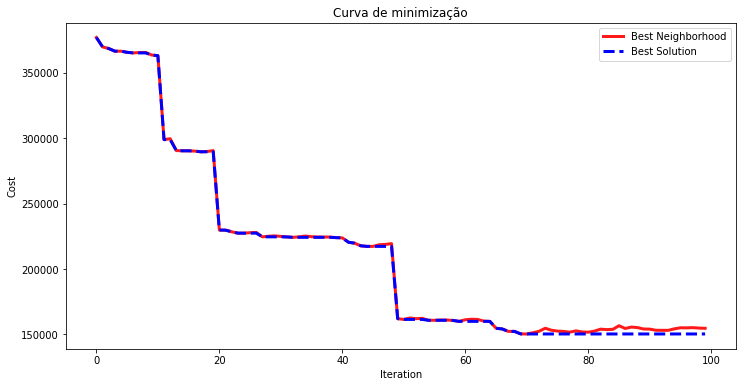

In [544]:
import matplotlib.pyplot as plt

x = np.arange(0, tabu.max_iterations, 1)
y1 = tabu.best_neighborhood["y"]
y2 = tabu.best_solutions["y"]
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
lines = ax.plot(x, y1, color='red', lw=3, alpha=0.9)

ax.plot(x, y2, color='blue', lw=3, linestyle='--')
ax.set_title('Curva de minimização')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.legend(['Best Neighborhood', 'Best Solution'])
plt.show()